In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from tqdm.auto import tqdm

In [200]:
a_max = 1.
a_min = 0.
na = 401
alpha, dalpha = np.linspace(a_min, a_max, num=na, retstep=True)
r_d = 0.25
r_b = 0.5
p_l = 1e-8
T_d = 700
T_p = 5e6
p_d = T_d * p_l
p_p = T_p * p_l
p_mut = 1 - (1 - p_d) * (1 - p_p)
p_pos = T_d / (T_d + T_p)
s_p = 0.001 * r_b
s_d = 0.2 * r_b

# mean and variance for double exponential distribution (without truncation)
mean_mut_effect = p_pos * s_d - (1 - p_pos) * s_p
var = p_pos * s_d**2 + (1 - p_pos) * s_p**2

mu = np.linspace(-(a_max-a_min), a_max-a_min, 2 * na - 1)
tmax = 40000
dens0 = 1 - r_d / r_b

# K = 500
Ncrit = T_p * (s_p / r_b) / T_d / (s_d/r_b)**2
mucrit = s_d / T_p / r_b
K = np.ceil(Ncrit * 4)  # check mcfarland theory

In [ ]:
files = ['lgca_cancerdfe_4_isolated_05Ncrit.pickle', 'lgca_cancerdfe_4_isolated_10Ncrit.pickle',
         'lgca_cancerdfe_4_isolated_20Ncrit.pickle']
densities = []
mean_props = []
std_mean_props = []
for i, file in tqdm(enumerate(files)):
    with open(file, 'rb') as f:
        lgca = pkl.load(f)

    tmax = len(lgca.dens_t)
    densities.append(lgca.dens_t.reshape((tmax + 1, -1)))
    prop = np.array(lgca.props['r_b'])
    cells_t = lgca.nodes_t.sum(-1).reshape((tmax + 1, -1))
    prop_t = [[prop[cells] if len(cells) > 0 else np.array([np.nan]) for cells in cells_t[t]] for t in range(tmax + 1)]
    mean_prop_t = np.array(
        [[np.mean(prop) if len(prop) > 0 else np.nan for prop in prop_t[t]] for t in range(tmax + 1)])
    std_mean_prop_t = np.array(
        [[np.std(prop, ddof=1, axis=-1) if len(prop) > 0 else np.nan for prop in prop_t[t]] for t in range(tmax + 1)])
    mean_props.append(mean_prop_t)
    std_mean_props.append(std_mean_prop_t)
    # var_prop_t = np.array([np.var(prop, ddof=1) if len(prop) > 0 else np.nan for prop in prop_t])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


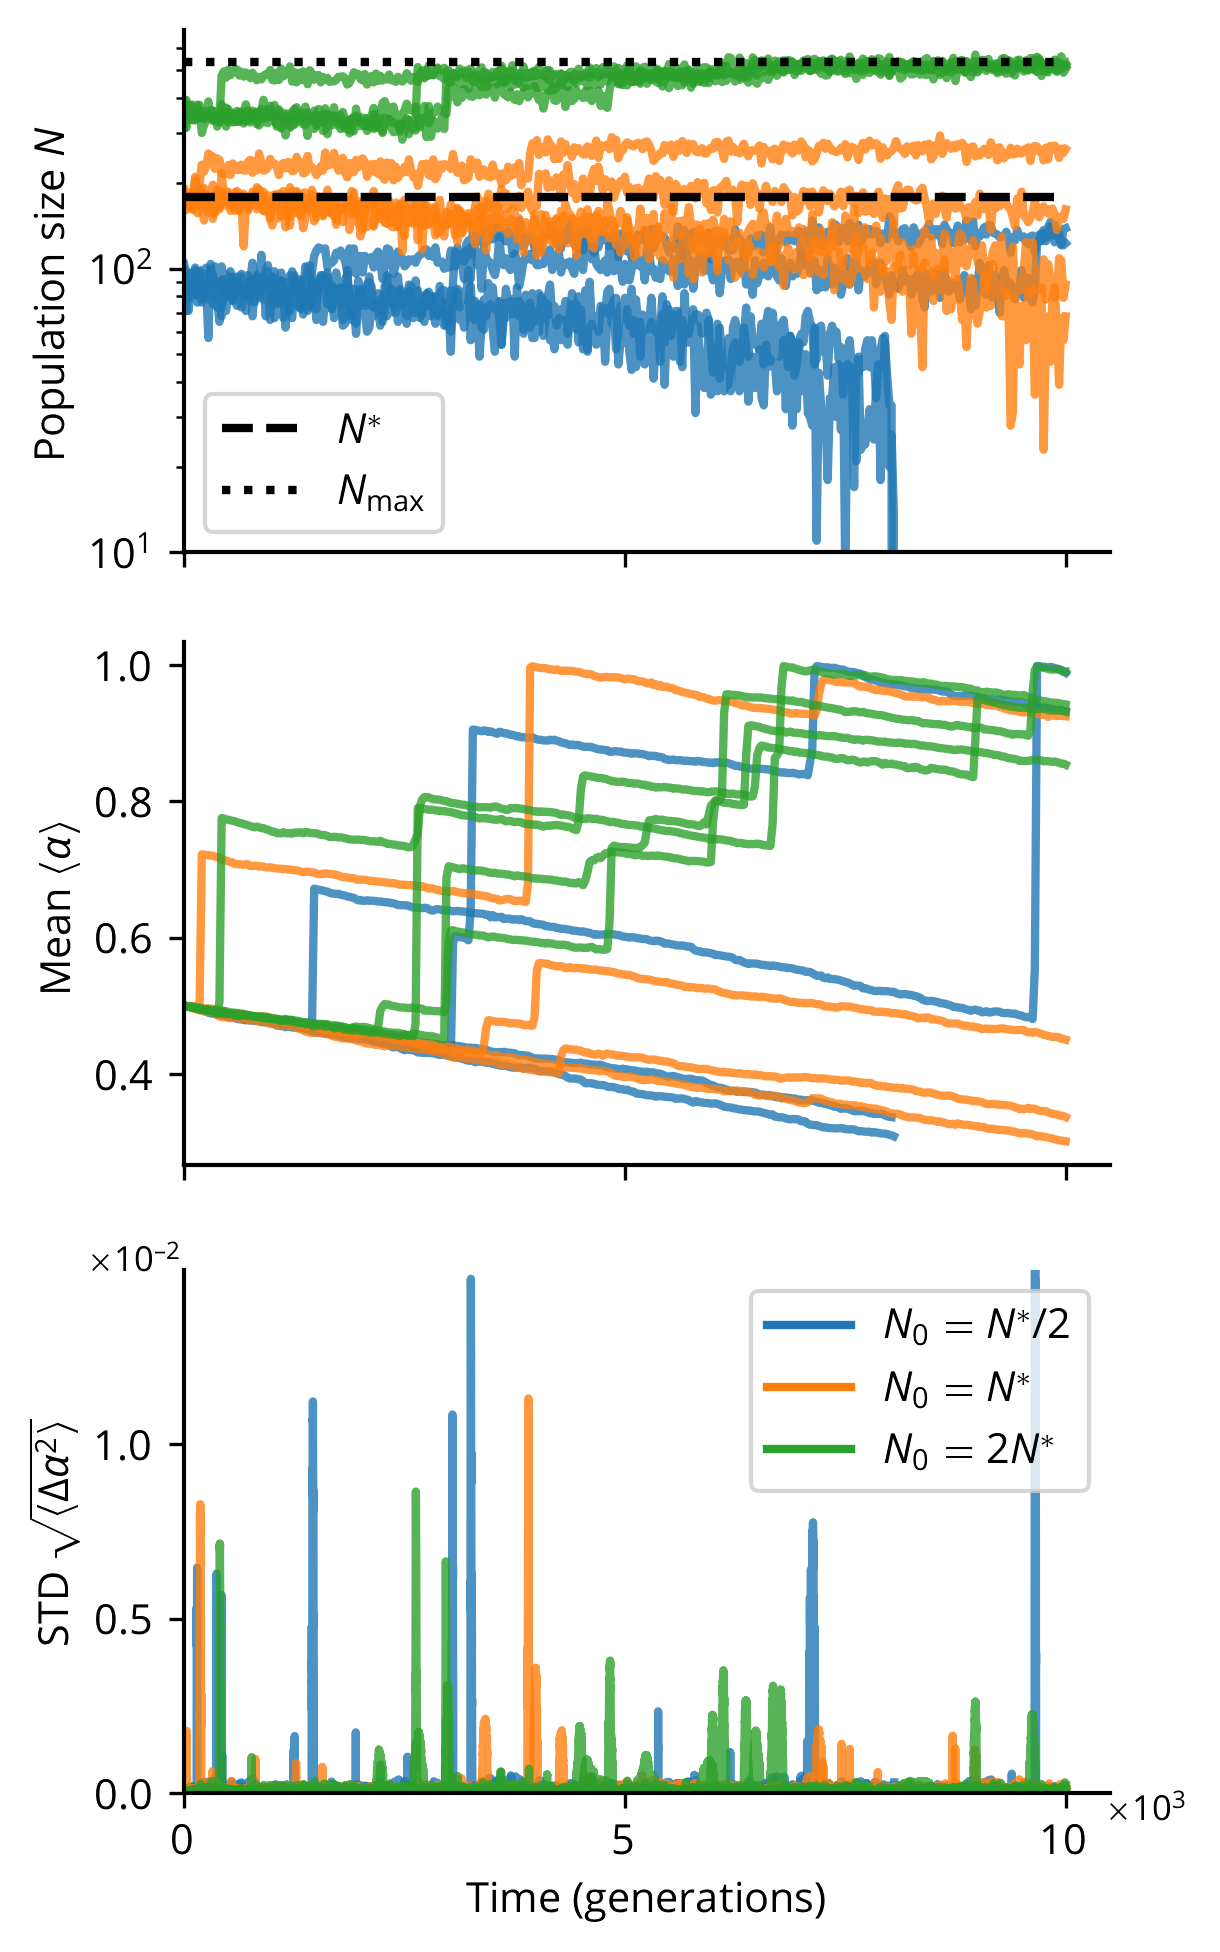

In [198]:
from matplotlib.ticker import FuncFormatter
golden_ratio = (np.sqrt(5) - 1.0) / 2.0
# get default figsize
wi, le = plt.rcParams['figure.figsize']
wi = 0.7 * wi
le = wi / golden_ratio

fig = plt.figure(constrained_layout=True, figsize=(wi, le))# , nrows=2, ncols=2, sharey=True, sharex=True, figsize=(wi, 0.9*wi/golden_ratio),
                        # gridspec_kw={'hspace': 0.1, 'wspace': 0.1}, tight_layout=True)
ax = fig.subplots(3, 1, sharey=False, sharex=True, gridspec_kw={'hspace': 0.1, 'wspace': 0.05})
plt.sca(ax[0])
skip = 100
Nmax = K * (1 - r_d)
x = np.arange(tmax+1)[::skip] / 4
for i, density in enumerate(densities):
    plt.plot(x, density[::skip], c='C{}'.format(i), alpha=.8)

plt.yscale('log')
plt.ylim(10, 1.3*Nmax)
plt.plot([0, tmax/4], [Ncrit, Ncrit], 'k--', label='$N^*$')
plt.plot([0, tmax/4], [Nmax, Nmax], 'k:', label=r'$N_{\max}$')
plt.legend()

plt.ylabel('Population size $N$')

plt.sca(ax[1])
for i, alpha in enumerate(mean_props):
    plt.plot(x, alpha[::skip], c='C{}'.format(i), alpha=.8)

plt.ylabel(r'Mean $\left\langle\alpha\right\rangle$')

plt.sca(ax[2])
skip= 1
Nmax = K * (1 - r_d)
x = np.arange(tmax+1)[::skip] / 4
for i, alpha in enumerate(std_mean_props):
    plt.plot(x, alpha[::skip], c='C{}'.format(i), alpha=.8)

plt.xlabel('Time (generations)')
plt.ylabel(r'STD $\sqrt{\left\langle\Delta\alpha^2\right\rangle}$')
# plt.yscale('log')
plt.ylim(0, .015)
plt.xlim(0)

# create a function to format the y axis labels
def format_y_ticks(tick_val, pos):
    return f'{tick_val * 10**2 :.1f}'

# apply the formatter
ax[-1].yaxis.set_major_formatter(FuncFormatter(format_y_ticks))

# Add scale next to the y-axis
ax[-1].text(-0.1, 1.0, r'$\times 10^{-2}$', transform=ax[-1].transAxes, fontsize='small')
ax[-1].set_yticks([0.0, 0.005, 0.01])
ax[-1].set_xticks([0, 5000, 10000], [0, 5, 10])
ax[-1].text(1.0, -0.05, r'$\times 10^{3}$', transform=ax[-1].transAxes, fontsize='small')

leg = plt.legend()
lines, labels = plt.gca().get_legend_handles_labels()
lines += [plt.Line2D([0], [0], c=c) for c in ['C0', 'C1', 'C2']]
labels += ['$N_0 = N^*/2$', '$N_0 = N^*$', '$N_0 = 2 N^*$']
plt.legend(lines, labels, loc='best')
# plt.tight_layout()
# plt.savefig('mullersratchet_N.pdf')